In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<AxesSubplot:title={'center':'Daily Total Precipitation'}, xlabel='date'>

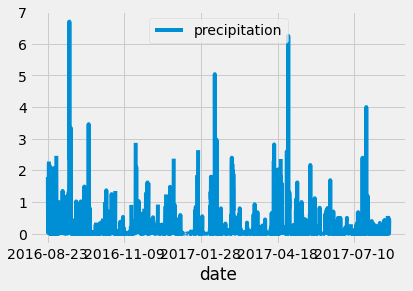

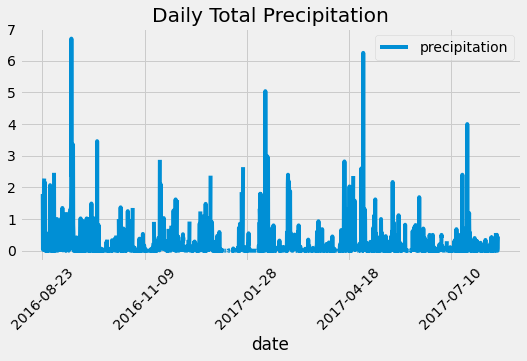

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# # results = [] # create variable to store results of query
#.# results = session.query(Measurement.date, Measurement.prcp)
#..# results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year)
#..# print(results.all())
results = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date >= prev_year).all()
#print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)
#print(df)
#print(df.to_string(index=False))

# Sort the dataframe by date
df = df.sort_index()
#print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the data
#df.plot()
#.# print(df.dtypes)
#.#  output is:
#.#      date              object
#.#      precipitation    float64
#.#      dtype: object
#two column conversions below as modified from ...
# .. website: https: //www.marsja.se/pandas-convert-column-to-datetime/
#df['date'] = df['date'].astype('datetime64[ns]')
#df['date'] = df['date'].astype('str')
#print(type(df['date'][0]))
df.plot()
df.plot(rot=45, figsize=(8,4), fontsize=14, title='Daily Total Precipitation')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
## #df.index.unique()
## print(f"numbers of daily station readings = {df.index.value_counts().unique()}\
##       \nmin station readings = {df.index.value_counts().min()}\
##       \nmax station readings = {df.index.value_counts().max()}")

#session.query() #add starting point for query
#session.query(func.count) #count dataset of interest
#session.query(func.count(Station.station)) #reference `Station.station` for number of stations
# ... add `.all()` so that results are returned as a list ...
session.query(func.count(Station.station)).all()

[(9,)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
## session.query() #begin with function for starting every SQLAlchemy query
## session.query(Measurement.station, func.count(Measurement.station)) #core query
## ... with core query having parameters to list stations and counts ...
## ... add filters to narrow data to show only what we need ...
## ... so use `groupby()` function [`group_by()` in SQLite] on the 'Measurement.station' class ...
## session.query(Measurement.station, func.count(Measurement.station)).\
##    group_by(Measurement.station)
## ... then add `order_by()` function to order results in order specified (here, descending) ...
## session.query(Measurement.station, func.count(Measurement.station)).\
##    group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
## ... then add `.all()` function to return all results of query ...
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
## session.query() #starting query code
## ... `func.min`, `func.max`, and `func.avg` to calculate, respectively the min, max, avg temps ...
## session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
## ... filter for station of interest (most-active from previous-cell query) ...
## session.query(func.min(Measurement.tobs)), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
## filter(Measurement.station == 'USC00519281')
## ... add the `.all()` function to return results as a list ...
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

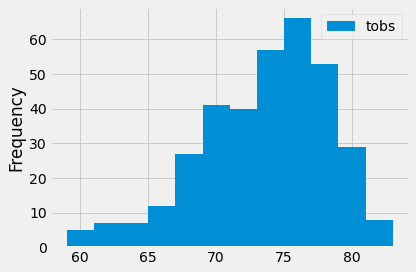

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
## session.query(Measurement.tobs) #first select column of interest
## ... then filter out all but most active station ...
## results = session.query(Measurement.tobs).\
## filter(Measurement.station == 'USC00519281')
## ... apply another filter to consider only most recent year; then add `.all()` to save results as a list ...
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()

## # print(results)

df = pd.DataFrame(results, columns=['tobs'])
## # print(df)
## # print(df.to_string(index=False))

## find right balance of bins(^) -- we'll use 12 -- for enough but not too much detail for histogram
## note that only *number* of bins required, *not* the ranges into which the data is to be separated
## (^) recommended to stay within a range of 5 to 20 bins
df.plot.hist(bins=12)

## ... compress x-axis labels so to fit into box holding the plot ...
## ... note that although may not change this particular graph much, ...
## ... "can be a lifesaver in situations where x-axis doesn't fit into the box ...
## ... (the) cosmetic change ... makes a big difference when presenting professional work."
plt.tight_layout()

## ... Note that viewing histogram plot created (below), "can infer that a vast majority of the
## ... observations were over 67 degrees. ...count up the bins to the right of 67 degrees (and)
## ... get about 325 days where it was over 67 degrees when the temperature was observed."

In [ ]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


# Challenge